In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import warnings
warnings.filterwarnings('ignore')
get_ipython().run_line_magic('matplotlib', 'notebook')
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [31]:
class importTickerData:
    def __init__(self, ticker, start_data):
        self.ticker = ticker
        self.start_data = start_data
        
    def calRSI(self, series, period):
        delta = series.diff().dropna()
        ups = delta * 0
        downs = ups.copy()
        ups[delta > 0] = delta[delta > 0]
        downs[delta < 0] = -delta[delta < 0]
        ups[ups.index[period-1]] = np.mean( ups[:period] )
        ups = ups.drop(ups.index[:(period-1)])
        downs[downs.index[period-1]] = np.mean( downs[:period] )
        downs = downs.drop(downs.index[:(period-1)])
        rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() 
        return 100 - 100 / (1 + rs)
    
    def calSMI(self, data):
        exp = 3
        dexp = 3
        data['C'] = (data['High'].rolling(10).max()+data['Low'].rolling(10).min())/2
        data['H'] = data['Close'] - data['C']
        data['HS1'] = data['H'].ewm(span=exp, adjust=False).mean()
        data['HS2'] = data['HS1'].ewm(span=dexp, adjust=False).mean()
        data['DHL2'] = ((data['High'].rolling(10).max() - data['Low'].rolling(10).min()).ewm(span=exp, adjust=False).mean()).ewm(span=dexp, adjust=False).mean()/2
        data['SMI'] = (data['HS2']/data['DHL2'])*100
        data['SIG'] = data['SMI'].ewm(span=10, adjust=False).mean()
        return data
    
    def calSRSI(self, data):
        data['low_N'] = (data['RSI'].rolling(14).min())
        data['high_N'] = (data['RSI'].rolling(14).max())
        data['SRSI'] = 100 * ((data['RSI'] - data['low_N']) / (data['high_N'] - data['low_N']))
        data['K'] = data.SRSI.rolling(window=3, center=False).mean().round(4)
        data['D'] = data.K.rolling(window=3, center=False).mean().round(4)
        return data
    
    def genSignals(self, data):
        data['smiSignal'] = np.where(data['SMI'] < -80, 1, 0)
        data['srsiSignal'] = np.where(np.logical_and(np.less(data.K, 1.2), np.less(data.D, 1.2)), 1, 0)
        data['rsiSignal'] = np.where(data['RSI'] < 30, 1, 0)
        return data
    
    def genSignalsOverbought(self, data):
        data['smiSignal'] = np.where(data['SMI'] > 80, 1, 0)
        data['srsiSignal'] = np.where(np.logical_and(np.greater(data.K, 90), np.greater(data.D, 90)), 1, 0)
        data['rsiSignal'] = np.where(data['RSI'] > 70, 1, 0)
        return data
    
    def filterData(self, data):
        data = data.drop(columns=['C','H','HS1','HS2','DHL2','low_N','high_N','SRSI'])
        data = data.dropna()
        data = data.reset_index()
        return data
    
    def importDataWeekly(self, data):
        agg_dict = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'}
        data = data.resample('W').agg(agg_dict)
        data['Log'] = np.log(data['Close']/data['Close'].shift(1)).dropna()
        data['RSI'] = self.calRSI(data['Close'], 14)
        data = self.calSMI(data)
        data = self.calSRSI(data)
        #data = self.genSignals(data)
        data = self.genSignalsOverbought(data)
        data = self.filterData(data)
        return data
    
    def importDataDaily(self, data):
        data['Log'] = np.log(data['Close']/data['Close'].shift(1)).dropna()
        data['RSI'] = self.calRSI(data['Close'], 14)
        data = self.calSMI(data)
        data = self.calSRSI(data)
        data = self.calSRSI(data)
        #data = self.genSignals(data)
        data = self.genSignalsOverbought(data)
        data = self.filterData(data)
        return data
    
    def importData(self):
        now = datetime.date.today()+datetime.timedelta(days=1)
        today = now.strftime("%Y-%m-%d")
        data = yf.download("{}".format(self.ticker), start="{}".format(self.start_data), end=today, interval = "1d", progress=False)
        data = data[['Open','Low','High','Close']]
        daily = self.importDataDaily(data)
        weekly = self.importDataWeekly(data)
        return daily, weekly


importSMI = importTickerData("TSLA", "2021-7-4")
SMI, SMI_W = importSMI.importData()
SMI.tail()
SMI_W.tail()

,Date,Open,High,Low,Close,Log,RSI,SMI,SIG,K,D,smiSignal,srsiSignal,rsiSignal
46,2023-01-01,117.500000,124.480003,108.239998,123.180000,0.000244,28.707222,-83.090861,-67.996278,0.0166,3.8248,0,0,0
47,2023-01-08,118.470001,118.800003,101.809998,113.059998,-0.085728,27.430599,-83.126582,-70.747242,0.0166,0.7823,0,0,0
48,2023-01-15,118.959999,125.949997,114.919998,122.400002,0.079376,30.502395,-78.269137,-72.114860,6.7187,2.2506,0,0,0
49,2023-01-22,125.699997,136.679993,124.309998,133.419998,0.086208,34.049515,-67.784401,-71.327504,21.1433,9.2929,0,0,0
50,2023-01-29,135.869995,146.500000,134.270004,143.889999,0.075547,37.322669,-52.660191,-67.933447,42.7260,23.5293,0,0,0


<IPython.core.display.Javascript object>


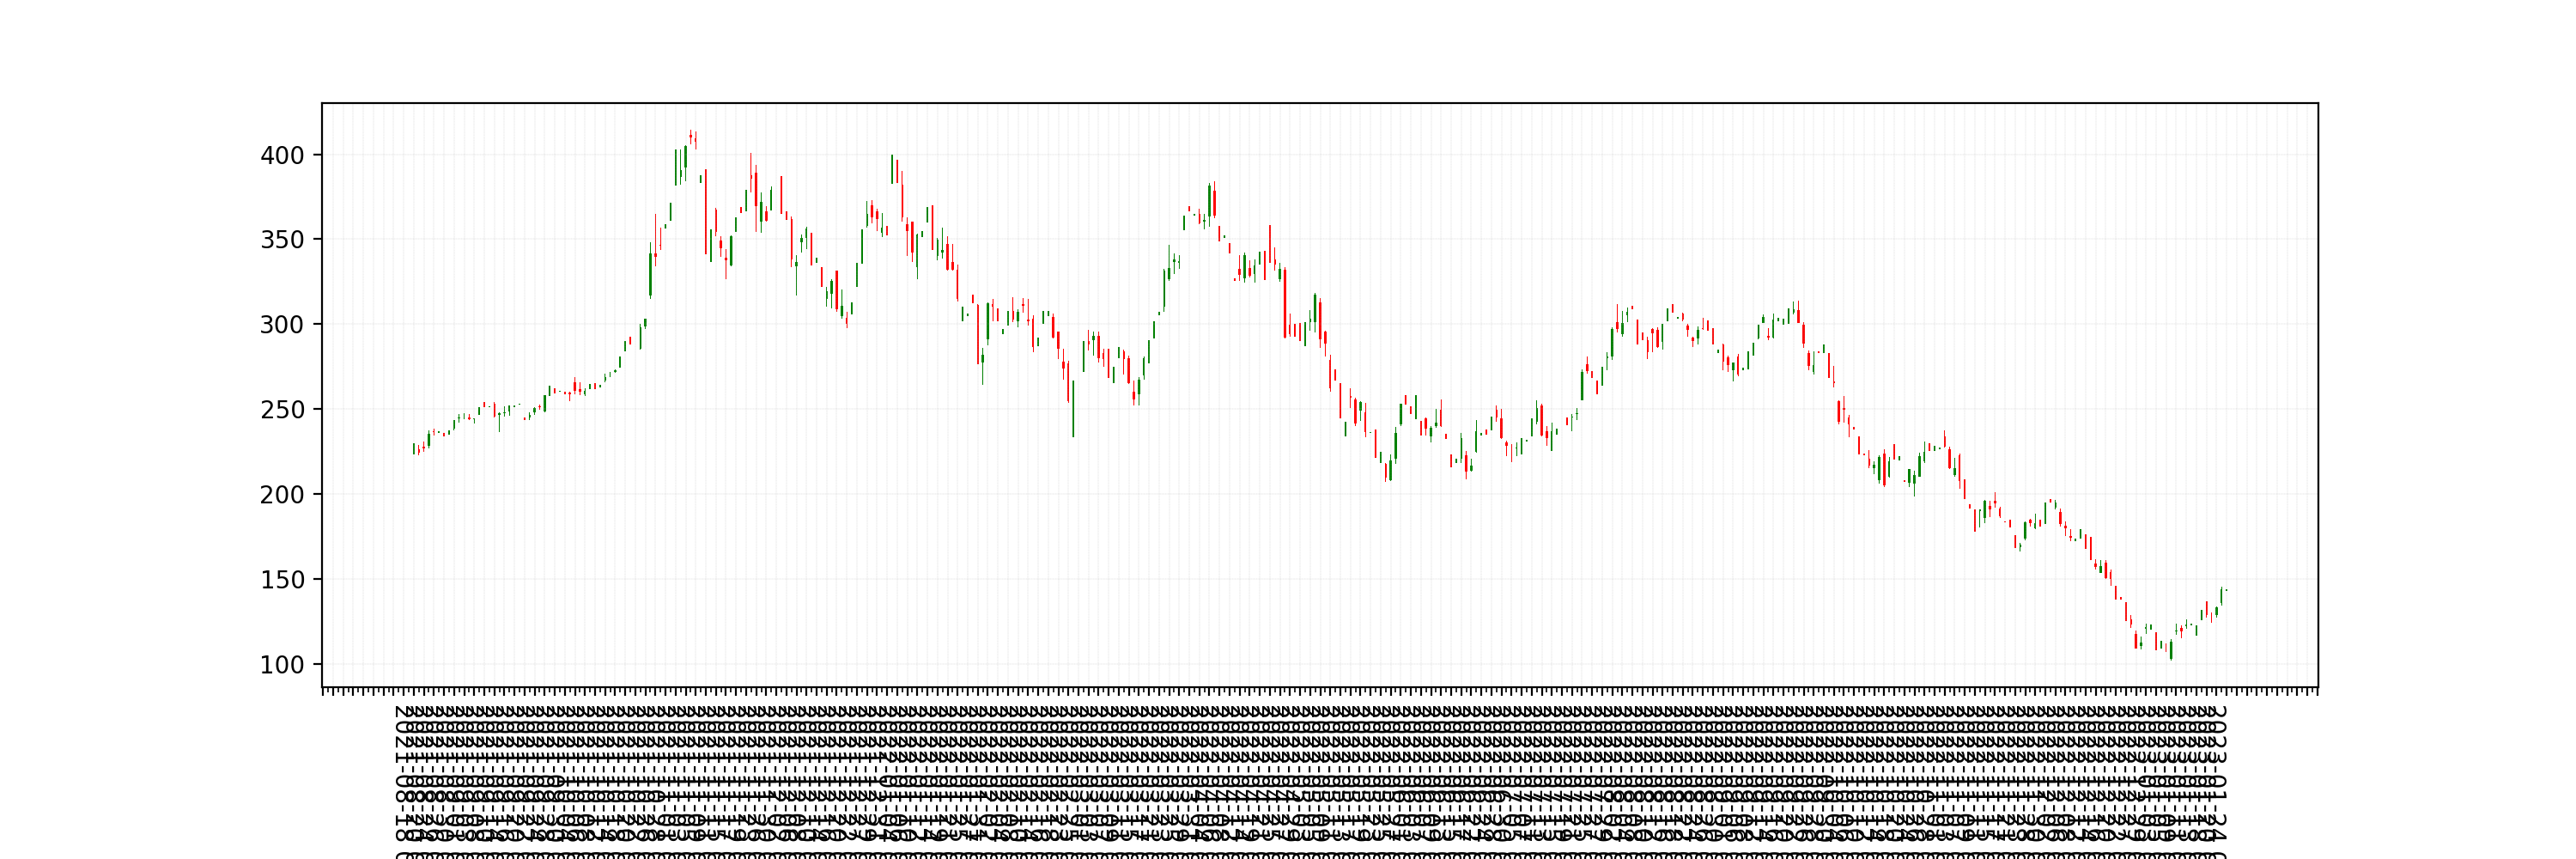

<IPython.core.display.Javascript object>


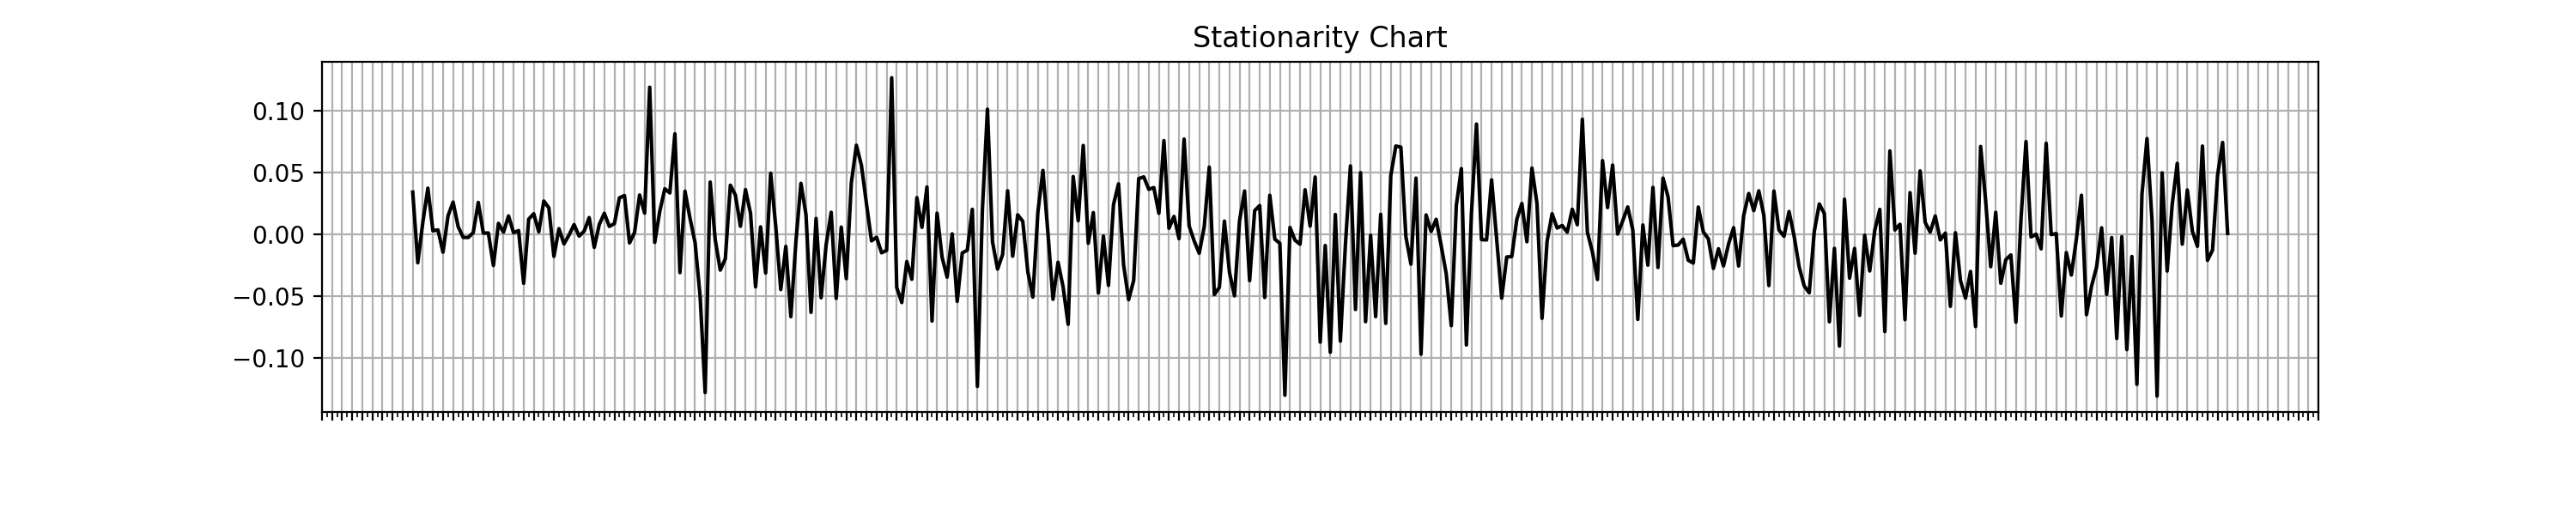

<IPython.core.display.Javascript object>


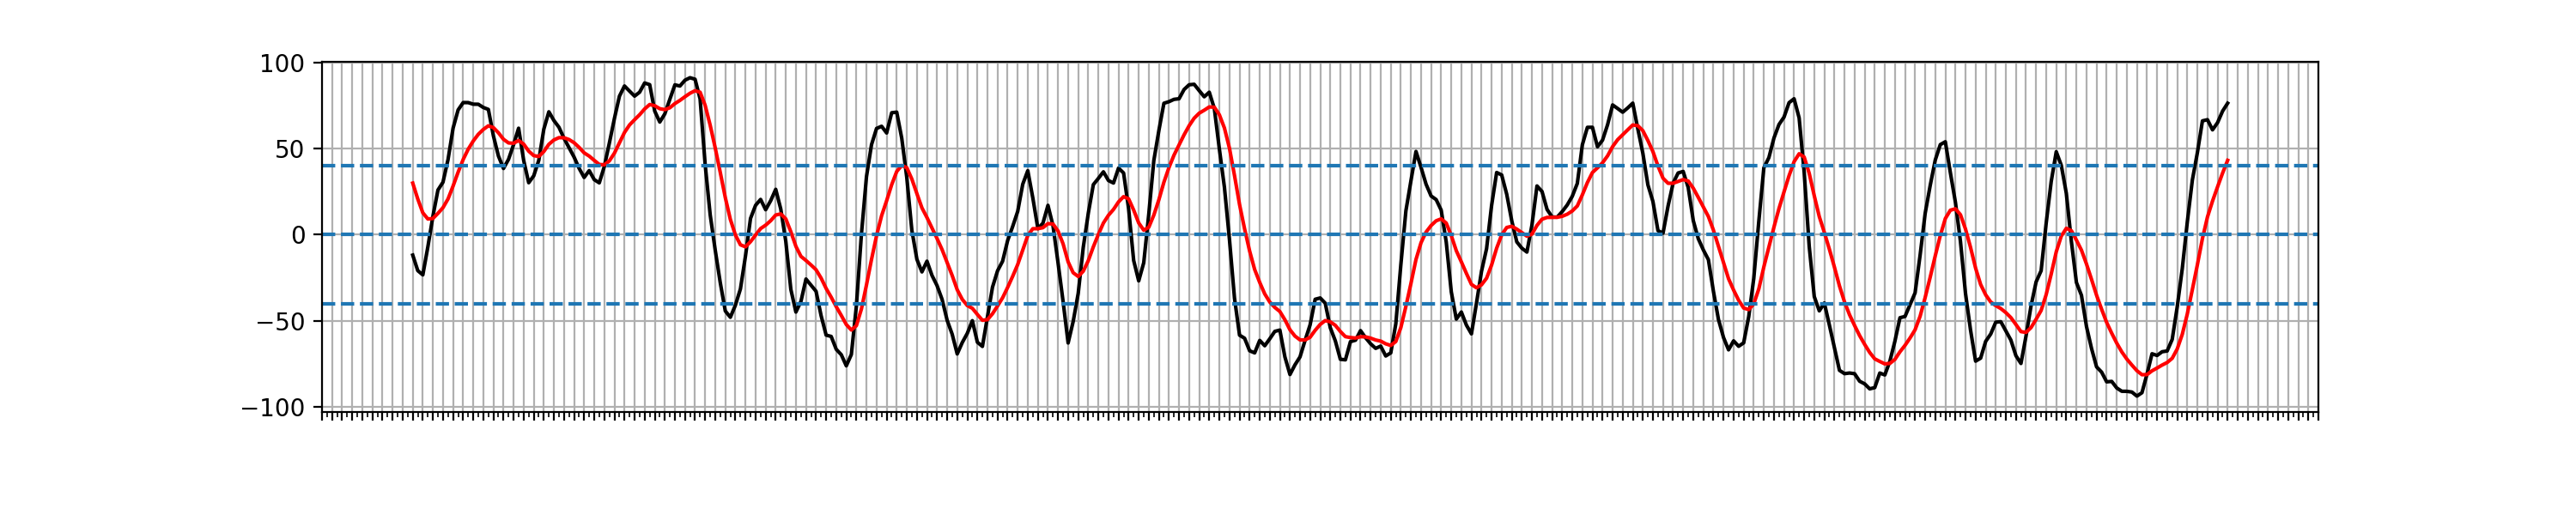

<IPython.core.display.Javascript object>


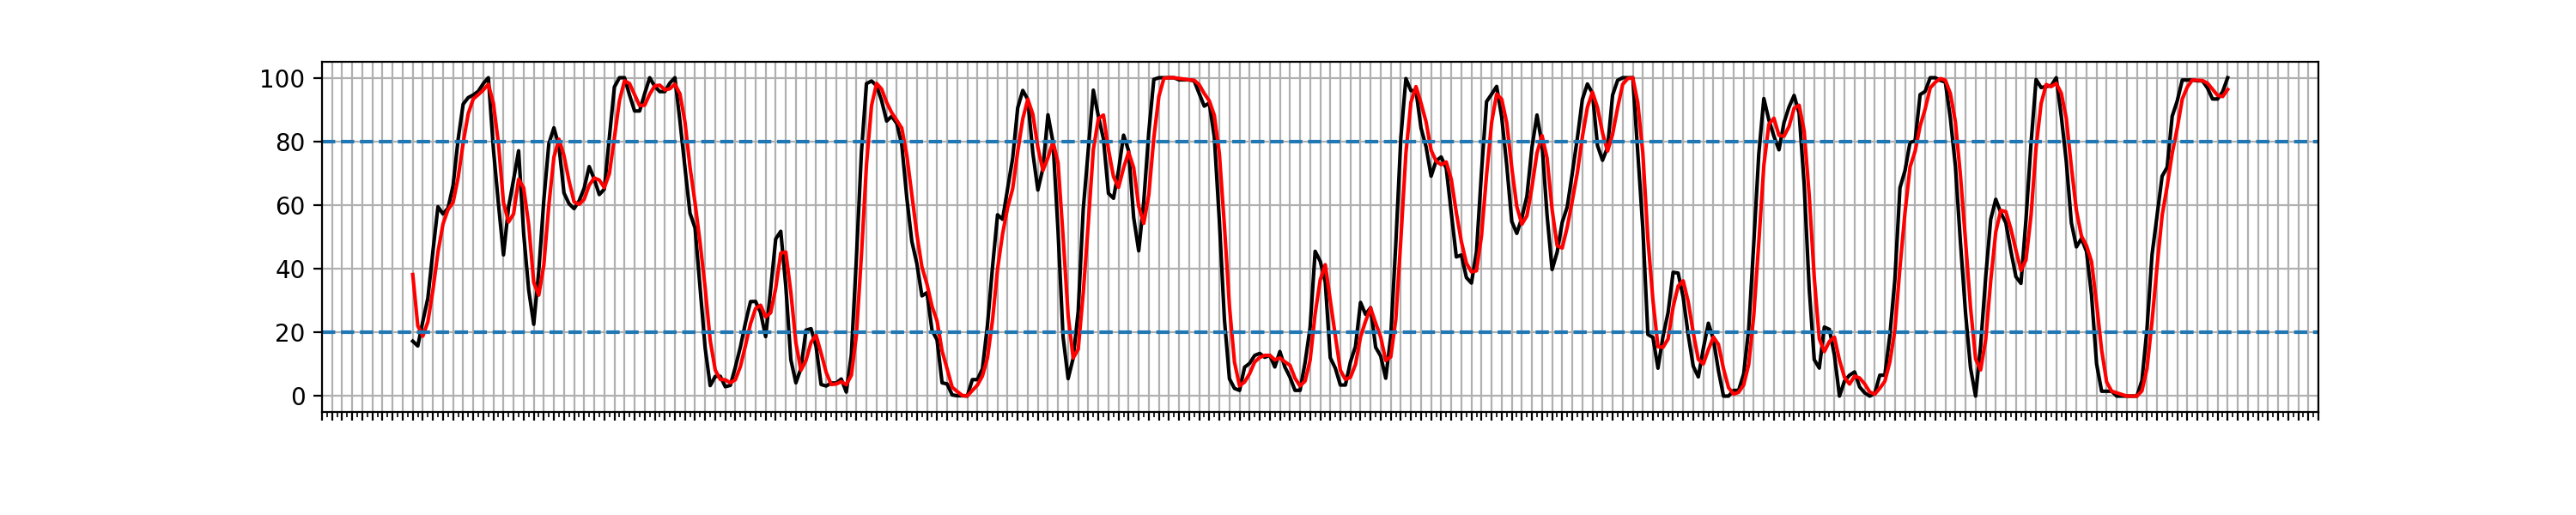

<IPython.core.display.Javascript object>


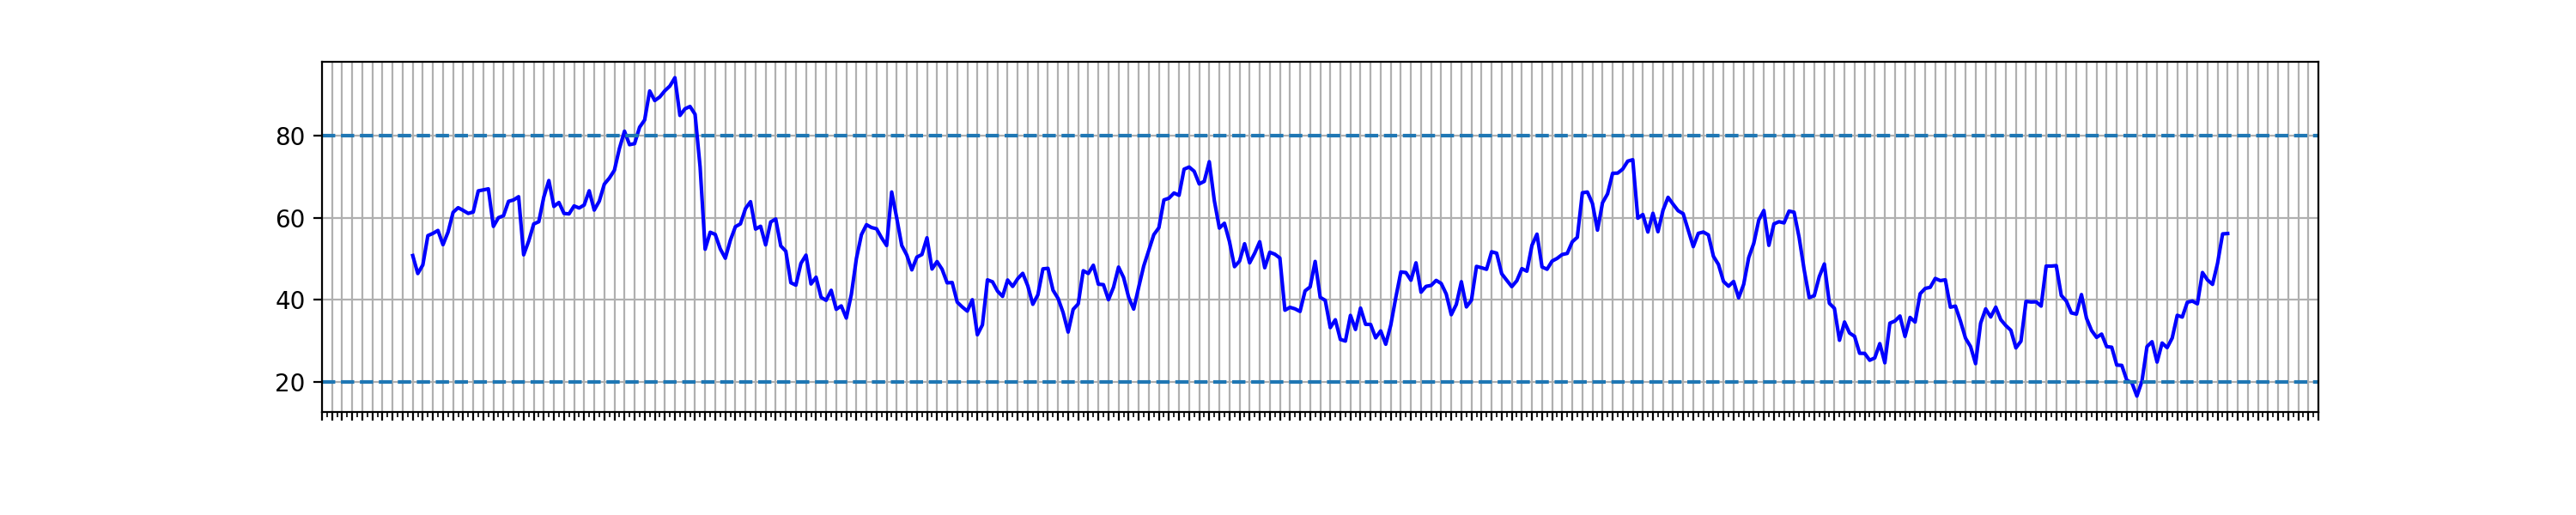

In [32]:
import matplotlib.ticker as plticker
from matplotlib.ticker import MultipleLocator


fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax.grid(linestyle='--', linewidth=0.1)
width = .4
width2 = .1

#define up and down prices
up = SMI[SMI.Close>=SMI.Open]
down = SMI[SMI.Close<SMI.Open]

#define colors to use
col1 = 'green'
col2 = 'red'

#plot up prices
ax.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
ax.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

#plot down prices
ax.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
ax.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
ax.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)

ax.set_xticks(SMI.index, labels=SMI.Date)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

#Stationarity Chart
fig.autofmt_xdate(rotation=270)

fig, ax = plt.subplots()
fig.set_size_inches(15, 3)
ax.grid()
ax.plot(SMI.index, 'Log', data=SMI, color='black')


ax.set_xticks(SMI.index, labels=[])
plt.title("Stationarity Chart")
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.autofmt_xdate(rotation=270)

fig, ax = plt.subplots()
fig.set_size_inches(15, 3)
ax.grid()
ax.plot(SMI.index, 'SMI', data=SMI, color='black')
ax.plot(SMI.index, 'SIG', data=SMI, color='r')

ax.axhline(40, linestyle='--')
ax.axhline(0, linestyle='--')
ax.axhline(-40, linestyle='--')
ax.set_xticks(SMI.index, labels=[])

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.autofmt_xdate(rotation=270)

fig, ax = plt.subplots()
fig.set_size_inches(15, 3)
ax.grid()
ax.plot(SMI.index, 'K', data=SMI, color='black')
ax.plot(SMI.index, 'D', data=SMI, color='r')

ax.axhline(80, linestyle='--')
ax.axhline(20, linestyle='--')
ax.set_xticks(SMI.index, labels=[])
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.autofmt_xdate(rotation=270)


fig, ax = plt.subplots()
fig.set_size_inches(15, 3)
ax.grid()
ax.plot(SMI.index, 'RSI', data=SMI, color='blue')


ax.axhline(80, linestyle='--')
ax.axhline(20, linestyle='--')
ax.set_xticks(SMI.index, labels=[])
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.autofmt_xdate(rotation=270)

In [16]:
nasdaq = ["AAL", "AAOI", "AAON", "AAPL", "AAWW", "ABCB", "ABNB", "ACCD", "ACDC", "ACIW", "ACLS", "ACMR", "ACT", "ACVA", "ADBE", "ADEA", "ADI", "ADP", "ADSE", "ADSK", "ADTH", "ADTN", "ADV", "AEHR", "AEIS", "AEP", "AFRM", "AGIL", "AGYS", "AIMC", "AIP", "AIRG", "AKAM", "AKLI", "AKTS", "AKYA", "ALGM", "ALGT", "ALKT", "ALRM", "ALRS", "ALTO", "ALTR", "AMAL", "AMAT", "AMBA", "AMCX", "AMD", "AMKR", "AMNB", "AMOT", "AMPL", "AMRK", "AMRS", "AMSC", "AMSF", "AMSWA", "AMTB", "AMTX", "AMWD", "AMZN", "ANDE", "ANGI", "ANSS", "APA", "APEI", "APLD", "APP", "APPF", "APPH", "APPN", "APPS", "AQMS", "ARBK", "ARCB", "ARCC", "ARHS", "ARKO", "ARLP", "AROW", "ARQQ", "ARRY", "ARTNA", "ARVL", "ASLE", "ASML", "ASO", "ASPS", "ASTE", "ASTS", "ASUR", "ASYS", "ATCX", "ATEX", "ATLC", "ATNI", "ATRO", "ATSG", "ATVI", "AUGX", "AUR", "AVAV", "AVDX", "AVGO", "AVID", "AVNW", "AVO", "AVPT", "AVT", "AXON", "AXTI", "AY", "AZPN", "BAND", "BANF", "BANR", "BASE", "BATRK", "BBCP", "BBSI", "BCBP", "BCML", "BCOR", "BCOV", "BCPC", "BECN", "BEEM", "BFC", "BFIN", "BFST", "BGCP", "BGRY", "BHF", "BIGC", "BIRD", "BJRI", "BKNG", "BKR", "BL", "BLBD", "BLDE", "BLFY", "BLKB", "BLMN", "BLNK", "BLZE", "BMBL", "BMRC", "BNFT", "BOKF", "BPOP", "BPRN", "BRKL", "BRKR", "BRLT", "BRY", "BRZE", "BSET", "BSRR", "BSVN", "BSY", "BTBT", "BUSE", "BWB", "BWEN", "BWMN", "BWMX", "BYND", "BYRN", "BZFD", "CAC", "CACC", "CAKE", "CALB", "CALM", "CAMP", "CAR", "CARE", "CASA", "CASH", "CASS", "CATC", "CATY", "CBAN", "CBFV", "CBNK", "CBRL", "CBSH", "CCAP", "CCB", "CCBG", "CCCS", "CCEP", "CCLP", "CCNE", "CCOI", "CCRN", "CCSI", "CDLX", "CDNS", "CDRO", "CDW", "CDZI", "CECO", "CEG", "CELH", "CENX", "CERT", "CEVA", "CFB", "CFBK", "CFFN", "CFLT", "CG", "CGBD", "CGNX", "CHCO", "CHDN", "CHEF", "CHK", "CHMG", "CHRD", "CHRW", "CHTR", "CHUY", "CHX", "CIDM", "CIFR", "CINF", "CISO", "CIVB", "CLAR", "CLBK", "CLFD", "CLMB", "CLMT", "CLNE", "CLSK", "CMAX", "CMCO", "CMCSA", "CME", "CMLS", "CMPO", "CMPR", "CMTL", "CNDT", "CNOB", "CNSL", "CNTY", "CNXC", "CNXN", "COCO", "COHR", "COHU", "COIN", "COLB", "COLM", "COMM", "CONN", "COOP", "COST", "COUP", "COWN", "CPLP", "CPRT", "CPSI", "CPTN", "CRAI", "CRDO", "CRGE", "CRMT", "CRNC", "CROX", "CRSR", "CRTO", "CRUS", "CRWD", "CSCO", "CSGP", "CSGS", "CSSE", "CSTR", "CSWC", "CSWI", "CSX", "CTAS", "CTBI", "CTLP", "CTSH", "CURI", "CVBF", "CVCO", "CVCY", "CVGI", "CVGW", "CVLG", "CVLT", "CVT", "CWBC", "CWST", "CYXT", "CZFS", "CZNC", "CZR", "CZWI", "DAVE", "DBX", "DCOM", "DCT", "DDOG", "DENN", "DFLI", "DGII", "DH", "DIOD", "DISH", "DKNG", "DLHC", "DLTH", "DLTR", "DNUT", "DOCU", "DOMO", "DORM", "DOX", "DRCT", "DSEY", "DSGR", "DSP", "DUOL", "DXLG", "DXPE", "DZSI", "EA", "EBAY", "EBC", "EBMT", "EEFT", "EFSC", "EGAN", "EGBN", "EGHT", "EGIO", "EHTH", "EMBK", "ENPH", "ENTG", "ENVX", "EOSE", "EQBK", "ERIC", "ERIE", "ERII", "ESEA", "ESQ", "ESSA", "ETSY", "EVBG", "EVCM", "EVER", "EVGO", "EVLV", "EVOP", "EVRG", "EWBC", "EWCZ", "EXC", "EXFY", "EXLS", "EXPD", "EXPE", "EXPI", "EXPO", "EXTR", "FA", "FANG", "FARM", "FARO", "FAST", "FAT", "FBIZ", "FBMS", "FBNC", "FCAP", "FCCO", "FCEL", "FCNCA", "FCRD", "FDUS", "FEAM", "FELE", "FFBC", "FFIC", "FFIE", "FFIN", "FFIV", "FFNW", "FFWM", "FGBI", "FHB", "FIBK", "FINW", "FIP", "FISI", "FISV", "FITB", "FIVE", "FIVN", "FLIC", "FLL", "FLNC", "FLNT", "FLUX", "FLWS", "FLYW", "FMAO", "FMBH", "FMNB", "FNKO", "FNWB", "FNWD", "FOCS", "FORA", "FORM", "FORR", "FOX", "FOXA", "FOXF", "FRBA", "FRBK", "FRGI", "FRME", "FROG", "FRSH", "FRST", "FSBC", "FSBW", "FSFG", "FSLR", "FSTR", "FTAI", "FTCI", "FTDR", "FTEK", "FTHM", "FTNT", "FULT", "FVCB", "FWONA", "FWONK", "FWRD", "FWRG", "FXNC", "FYBR", "GABC", "GAIN", "GAMB", "GAN", "GASS", "GBDC", "GCMG", "GDEN", "GDRX", "GDYN", "GECC", "GEHC", "GEN", "GFS", "GIII", "GLAD", "GLDD", "GMGI", "GNSS", "GNTX", "GNTY", "GNUS", "GO", "GOCO", "GOGO", "GOOG", "GOOGL", "GP", "GPP", "GPRE", "GPRO", "GRWG", "GSBC", "GSHD", "GSM", "GT", "GTLB", "GTX", "GWRS", "HA", "HAFC", "HAIN", "HAS", "HBAN", "HBCP", "HBIO", "HBNC", "HBT", "HCCI", "HCKT", "HCP", "HDSN", "HEAR", "HEES", "HFWA", "HGBL", "HHS", "HIBB", "HLIT", "HLMN", "HLNE", "HLTH", "HMPT", "HMST", "HNRG", "HNST", "HNVR", "HOFV", "HON", "HONE", "HOOD", "HOPE", "HPK", "HQI", "HRZN", "HSII", "HSON", "HSTM", "HTBI", "HTBK", "HTLD", "HTLF", "HTOO", "HTZ", "HUBG", "HURN", "HWC", "HWKN", "HYFM", "HYZN", "IAC", "IAS", "IBCP", "IBKR", "IBTX", "ICFI", "ICHR", "ICMB", "IDBA", "IDCC", "IDEX", "IEP", "IHRT", "III", "IIIV", "IMMR", "IMXI", "INBK", "INDB", "INDI", "INFN", "INSE", "INSG", "INTA", "INTC", "INTU", "INTZ", "INVE", "IOSP", "IPAR", "IPGP", "IPWR", "IRDM", "ISPO", "ISTR", "ITI", "ITRI", "IVA", "IVAC", "JACK", "JAKK", "JAMF", "JBHT", "JBLU", "JJSF", "JKHY", "JOAN", "JRSH", "KALU", "KBAL", "KDP", "KE", "KELYA", "KFRC", "KHC", "KITT", "KLAC", "KLTR", "KLXE", "KNBE", "KOPN", "KPLT", "KRNY", "KRT", "KRUS", "KTOS", "KVHI", "LANC", "LASR", "LAUR", "LAZR", "LAZY", "LBAI", "LBC", "LBRDA", "LBRDK", "LBTYA", "LBTYK", "LCID", "LCNB", "LCUT", "LE", "LECO", "LEE", "LEGH", "LFUS", "LGIH", "LIDR", "LIFW", "LILA", "LILAK", "LILM", "LINC", "LITE", "LIVE", "LKFN", "LKQ", "LMB", "LMNR", "LMST", "LNT", "LNW", "LOCO", "LOGI", "LOPE", "LPLA", "LPRO", "LPSN", "LQDT", "LRCX", "LRFC", "LSCC", "LSTR", "LSXMA", "LSXMK", "LTCH", "LTRX", "LULU", "LVLU", "LVO", "LVOX", "LWAY", "LYFT", "LYLT", "LYTS", "LZ", "MANH", "MAPS", "MAR", "MARA", "MAT", "MATW", "MBCN", "MBIN", "MBUU", "MBWM", "MCFT", "MCHP", "MCHX", "MCRI", "MDB", "MDLZ", "MDRX", "MDWT", "MERC", "MESA", "META", "METC", "MFIC", "MFIN", "MGEE", "MGI", "MGNI", "MGPI", "MGRC", "MIDD", "MITK", "MKSI", "MKTW", "MKTX", "MLAB", "MLKN", "MMAT", "MMLP", "MMMB", "MNSB", "MNST", "MNTK", "MNTV", "MNTX", "MOFG", "MOND", "MPAA", "MPB", "MPWR", "MQ", "MRBK", "MRCC", "MRTN", "MRVL", "MSBI", "MSEX", "MSFT", "MSTR", "MTCH", "MTLS", "MTRX", "MTSI", "MTTR", "MU", "MVBF", "MVIS", "MVST", "MXL", "MYFW", "MYPS", "MYRG", "NATI", "NATR", "NAVI", "NBN", "NBTB", "NCNO", "NDAQ", "NDLS", "NDSN", "NECB", "NEOV", "NEWT", "NEXT", "NFBK", "NFE", "NFLX", "NKLA", "NKSH", "NMFC", "NMIH", "NMRK", "NN", "NNBR", "NRDS", "NRIM", "NSIT", "NSSC", "NTAP", "NTGR", "NTIC", "NTNX", "NTRS", "NUTX", "NVDA", "NVEE", "NVTS", "NWBI", "NWE", "NWL", "NWPX", "NWSA", "NXPI", "NXST", "OB", "OBNK", "OBT", "OCFC", "OCSL", "ODFL", "OESX", "OFS", "OKTA", "OLED", "OLK", "OLLI", "OMAB", "OMEX", "ON", "ONB", "ONDS", "ONEW", "OPAL", "OPBK", "OPEN", "OPRA", "OPRT", "ORGN", "ORLY", "ORRF", "OSBC", "OSIS", "OSPN", "OSS", "OSTK", "OTLY", "OTTR", "OXLC", "OXSQ", "OZK", "PAA", "PACW", "PAGP", "PANL", "PANW", "PARA", "PATK", "PAYA", "PAYO", "PAYS", "PAYX", "PBPB", "PCAR", "PCB", "PCT", "PCTY", "PCYG", "PDCE", "PDFS", "PEAR", "PEBO", "PEGA", "PENN", "PEP", "PET", "PETS", "PFBC", "PFC", "PFG", "PFHD", "PFIE", "PFIS", "PFX", "PGC", "PHUN", "PI", "PKOH", "PLAB", "PLAY", "PLBY", "PLCE", "PLL", "PLMR", "PLUG", "PLUS", "PLXS", "PLYA", "PNFP", "POET", "POOL", "POWI", "POWL", "POWW", "PPBI", "PPC", "PRAA", "PRCH", "PRDO", "PRFT", "PRGS", "PRIM", "PROV", "PRPL", "PRST", "PRTC", "PRTG", "PRTS", "PRVA", "PSMT", "PSNY", "PTC", "PTEN", "PTLO", "PTMN", "PTON", "PTRA", "PTSI", "PTVE", "PUBM", "PVBC", "PWFL", "PWP", "PXLW", "PXS", "PYCR", "PYPL", "PZZA", "QCOM", "QCRH", "QLYS", "QMCO", "QNST", "QRHC", "QRTEA", "QRVO", "QUIK", "RADI", "RAIL", "RBB", "RBBN", "RBCAA", "RCII", "RCKY", "RCM", "RCMT", "RDFN", "REAL", "REKR", "RELY", "RENT", "REYN", "RFIL", "RGCO", "RGF", "RGLD", "RGTI", "RICK", "RIDE", "RIOT", "RIVN", "RKLB", "RMBL", "RMBS", "RMNI", "RMR", "RNST", "RNW", "ROAD", "ROCC", "ROKU", "ROOT", "ROST", "ROVR", "RPAY", "RPD", "RRBI", "RRGB", "RRR", "RSSS", "RSVR", "RUM", "RUN", "RUSHA", "RUTH", "RVSB", "RXT", "RYAAY", "SABR", "SAIA", "SAL", "SAMG", "SANM", "SANW", "SASR", "SATS", "SBCF", "SBFG", "SBGI", "SBLK", "SBNY", "SBSI", "SBT", "SBUX", "SCHN", "SCOR", "SCPL", "SCSC", "SCVL", "SDGR", "SEAT", "SEIC", "SEV", "SFIX", "SFM", "SFNC", "SFST", "SGH", "SGML", "SHBI", "SHCR", "SHEN", "SHIP", "SHLS", "SHOO", "SHYF", "SIGI", "SIRI", "SITM", "SIVB", "SKIN", "SKYT", "SKYW", "SKYX", "SLAB", "SLDP", "SLM", "SLP", "SLRC", "SMBC", "SMBK", "SMCI", "SMMF", "SMPL", "SMSI", "SMTC", "SNBR", "SNCR", "SNCY", "SND", "SNEX", "SNPO", "SNPS", "SOFI", "SOLO", "SONO", "SOTK", "SOUN", "SOVO", "SP", "SPFI", "SPLK", "SPOK", "SPSC", "SPT", "SPTN", "SPWH", "SPWR", "SRAD", "SRAX", "SRCE", "SRCL", "SSB", "SSBK", "SSNC", "SSP", "SSSS", "SSTI", "SSYS", "STBA", "STEL", "STEP", "STER", "STGW", "STIX", "STKL", "STKS", "STLD", "STRA", "STRC", "STRL", "STRM", "STX", "SUMO", "SURG", "SWBI", "SWIM", "SWKH", "SWKS", "SYBT", "SYM", "SYNA", "TA", "TACT", "TASK", "TAST", "TBBK", "TCBI", "TCBK", "TCBX", "TCFC", "TCPC", "TDUP", "TENB", "TER", "TFIN", "TFSL", "TGAN", "TH", "THFF", "THRM", "THRN", "THRY", "TIGO", "TLS", "TMUS", "TOPS", "TPG", "TPIC", "TREE", "TRIN", "TRMB", "TRMK", "TRNS", "TROW", "TRST", "TRUE", "TRVG", "TSCO", "TSLA", "TSP", "TTD", "TTEC", "TTEK", "TTGT", "TTMI", "TTWO", "TW", "TWIN", "TWKS", "TWNK", "TWOU", "TXN", "TXRH", "TZOO", "UAL", "UBSI", "UCBI", "UCTT", "UEIC", "UFCS", "UFPI", "ULBI", "ULCC", "ULH", "UMBF", "UMPQ", "UNTY", "UPLD", "UPST", "UPXI", "URBN", "USAP", "USCB", "USEG", "UVSP", "VBTX", "VC", "VCSA", "VCTR", "VECO", "VERI", "VERX", "VIAV", "VICR", "VIEW", "VIRC", "VIRT", "VITL", "VLDR", "VLY", "VMEO", "VNOM", "VOD", "VOXX", "VRA", "VRM", "VRNS", "VRNT", "VRRM", "VRSK", "VRSN", "VRTS", "VSAT", "VTNR", "VTSI", "VUZI", "VWE", "WABC", "WAFD", "WALD", "WASH", "WATT", "WBA", "WBD", "WDAY", "WDC", "WDFC", "WEN", "WERN", "WEST", "WFRD", "WGS", "WHF", "WING", "WIRE", "WKHS", "WLDN", "WMG", "WMPN", "WNEB", "WPRT", "WRAP", "WSBC", "WSBF", "WSC", "WSFS", "WTBA", "WTFC", "WTW", "WULF", "WW", "WWD", "WYNN", "XAIR", "XEL", "XM", "XMTR", "XOS", "XPEL", "YELL", "YORW", "Z", "ZBRA", "ZD", "ZEUS", "ZFOX", "ZG", "ZI", "ZION", "ZM", "ZS"]
nyse = ["A", "AAP", "AB", "ABB", "ABG", "ABM", "ACCO", "ACEL", "ACHR", "ACI", "ACM", "ACN", "ADT", "AEE", "AEG", "AEL", "AEO", "AER", "AES", "AFG", "AFL", "AGCO", "AGM", "AGR", "AGRO", "AGS", "AIG", "AIN", "AIR", "AIT", "AIZ", "AJG", "AJRD", "AL", "ALB", "ALE", "ALG", "ALK", "ALL", "ALLE", "ALLG", "ALLY", "ALSN", "ALV", "AM", "AMBC", "AME", "AMG", "AMK", "AMP", "AMPY", "AMR", "AMRC", "AMWL", "AMX", "AN", "ANF", "AON", "AOS", "APAM", "APD", "APH", "APTV", "AQUA", "ARCH", "ARLO", "AROC", "ARW", "ASB", "ASGN", "ASH", "ASIX", "ASPN", "ASR", "ATCO", "ATGE", "ATI", "ATKR", "ATO", "ATUS", "AUB", "AVD", "AVNT", "AWK", "AWR", "AX", "AXL", "AXP", "AXTA", "AYI", "AYX", "AZZ", "B", "BA", "BAC", "BAH", "BALL", "BANC", "BBDC", "BBVA", "BBW", "BBY", "BC", "BCAT", "BCO", "BCS", "BDC", "BEN", "BEP", "BERY", "BFAM", "BFH", "BG", "BGS", "BGSF", "BHE", "BHLB", "BIG", "BIO", "BJ", "BK", "BKH", "BKKT", "BKU", "BLD", "BLDR", "BLK", "BMI", "BN", "BOC", "BODY", "BOH", "BOOT", "BOWL", "BOX", "BP", "BR", "BRBR", "BRC", "BRO", "BSIG", "BSM", "BTU", "BUD", "BV", "BVH", "BW", "BWA", "BX", "BXC", "BY", "BYD", "BZH", "C", "CABO", "CACI", "CADE", "CAG", "CAL", "CALX", "CAPL", "CAT", "CB", "CBRE", "CBT", "CBU", "CBZ", "CC", "CCK", "CCO", "CCRD", "CCS", "CDAY", "CDE", "CE", "CEQP", "CF", "CFG", "CFR", "CHD", "CHH", "CHS", "CIEN", "CIR", "CIVI", "CL", "CLB", "CLW", "CMA", "CMC", "CMG", "CMI", "CMP", "CMRE", "CMS", "CNA", "CNK", "CNO", "CNP", "CNX", "CODI", "COF", "COP", "COTY", "CPB", "CPE", "CPF", "CPK", "CPS", "CR", "CRH", "CRI", "CRK", "CRL", "CRM", "CRS", "CS", "CSTM", "CSV", "CTRA", "CTS", "CUBI", "CVNA", "CVX", "CWEN", "CWH", "CWT", "CX", "D", "DAC", "DAL", "DAN", "DAR", "DAVA", "DB", "DBD", "DBI", "DCI", "DCO", "DCP", "DDD", "DDS", "DE", "DECK", "DEO", "DFS", "DG", "DHT", "DHX", "DIN", "DINO", "DIS", "DK", "DKL", "DKS", "DLB", "DLX", "DMS", "DNB", "DOCN", "DOV", "DPZ", "DRI", "DRQ", "DSX", "DT", "DTE", "DUK", "DVN", "DY", "E", "EAF", "EAT", "EB", "ECC", "ECL", "ECVT", "ED", "EFX", "EFXT", "EGLE", "EGY", "EIG", "EIX", "EL", "ELF", "ELVT", "EME", "EMN", "EMR", "ENB", "ENOV", "ENR", "ENS", "ENV", "ENVA", "EOG", "EPAC", "EPAM", "EPD", "EQNR", "EQT", "ES", "ESE", "ESI", "ESTC", "ESTE", "ET", "ETD", "ETN", "ETR", "EVC", "EVR", "EVRI", "EXP", "F", "FAF", "FBK", "FC", "FCF", "FCN", "FCX", "FDX", "FE", "FHI", "FHN", "FICO", "FINV", "FIS", "FIX", "FL", "FLO", "FLR", "FLS", "FLT", "FMC", "FMX", "FNB", "FNF", "FOR", "FOUR", "FRC", "FSS", "FTK", "FUL", "FUN", "GATO", "GATX", "GBCI", "GBTG", "GBX", "GD", "GDDY", "GDOT", "GE", "GEL", "GFF", "GGG", "GHI", "GHM", "GIC", "GIL", "GIS", "GL", "GLP", "GLW", "GM", "GNK", "GNRC", "GOLF", "GPC", "GPI", "GPK", "GPN", "GPOR", "GPS", "GRBK", "GRC", "GRMN", "GS", "GSBD", "GSL", "GTLS", "GTN", "GVA", "GWH", "GWRE", "GWW", "H", "HAL", "HBI", "HCI", "HD", "HEI", "HES", "HESM", "HI", "HIG", "HII", "HL", "HLI", "HLIO", "HLLY", "HLX", "HMN", "HNI", "HOG", "HOMB", "HOUS", "HP", "HPE", "HPQ", "HRB", "HRL", "HSBC", "HSC", "HSY", "HTGC", "HTH", "HUBB", "HUBS", "HUN", "HUYA", "HWM", "HXL", "HY", "HZO", "IBA", "IBM", "ICE", "IDA", "IEX", "IFF", "IGT", "IHG", "ING", "INGR", "INT", "IONQ", "IP", "IPG", "IPI", "IR", "IT", "ITT", "ITW", "IVZ", "JBL", "JBT", "JCI", "JEF", "JHX", "JLL", "JNPR", "JOBY", "JPM", "JWN", "K", "KAI", "KAMN", "KBR", "KEX", "KEY", "KEYS", "KFY", "KIND", "KKR", "KLR", "KMB", "KMI", "KMPR", "KMT", "KMX", "KNOP", "KNSL", "KNTK", "KNX", "KO", "KOF", "KOP", "KR", "KRO", "KRP", "KSS", "KWR", "LAD", "LAW", "LBRT", "LC", "LCII", "LDOS", "LEA", "LEG", "LEVI", "LHX", "LII", "LMND", "LMT", "LNC", "LNN", "LOB", "LOW", "LRN", "LTHM", "LUMN", "LUV", "LVS", "LXU", "LYB", "LYG", "LYV", "LZB", "M", "MA", "MAIN", "MAN", "MANU", "MAS", "MATV", "MATX", "MBI", "MCD", "MCO", "MCS", "MCY", "MDC", "MDU", "MED", "MEI", "MET", "MFC", "MG", "MGA", "MGM", "MGY", "MHK", "MHO", "MIR", "MKC", "MKFG", "MKL", "ML", "MLI", "MLM", "MMC", "MMM", "MMP", "MMS", "MOD", "MODG", "MODN", "MOS", "MOV", "MPC", "MPLX", "MRC", "MRO", "MS", "MSA", "MSCI", "MSGS", "MSI", "MSM", "MT", "MTB", "MTDR", "MTG", "MTH", "MTN", "MTW", "MTX", "MTZ", "MUR", "MUSA", "MUX", "MWA", "MX", "MYE", "NBHC", "NCLH", "NEE", "NEM", "NEP", "NET", "NEWR", "NEX", "NFG", "NGG", "NGL", "NI", "NIC", "NINE", "NJR", "NKE", "NLS", "NMM", "NOA", "NOC", "NOG", "NOK", "NOV", "NOVA", "NOW", "NRDY", "NRG", "NSC", "NSP", "NUE", "NVR", "NWG", "NWN", "NX", "NYCB", "NYT", "OCN", "OEC", "OGE", "OI", "OII", "OIS", "OKE", "OLN", "OMC", "ONTO", "OPAD", "ORA", "ORAN", "ORCL", "ORI", "ORN", "OSK", "OUST", "OVV", "OWL", "OXM", "OXY", "PAC", "PAG", "PAR", "PARR", "PB", "PBA", "PBF", "PBI", "PCG", "PEG", "PFGC", "PFLT", "PFS", "PFSI", "PG", "PGR", "PGTI", "PH", "PHX", "PII", "PIPR", "PJT", "PKG", "PLNT", "PLOW", "PNC", "PNM", "PNNT", "PNR", "POR", "POST", "PPG", "PPL", "PR", "PRA", "PRG", "PRI", "PRLB", "PRMW", "PRO", "PRU", "PSO", "PSX", "PUK", "PUMP", "PWR", "PWSC", "PX", "PXD", "QS", "R", "RAMP", "RBC", "RBLX", "RCL", "RDN", "RDW", "RELX", "RES", "REVG", "REX", "RF", "RFP", "RGA", "RH", "RHI", "RIG", "RJF", "RKT", "RL", "RLI", "RM", "RNGR", "ROK", "ROL", "ROP", "RPM", "RRC", "RRX", "RS", "RSG", "RTX", "RYAM", "RYI", "S", "SAH", "SAM", "SAN", "SAP", "SAR", "SAVE", "SCCO", "SCHW", "SCI", "SCL", "SCM", "SCS", "SCU", "SE", "SEAS", "SEE", "SF", "SFBS", "SHAK", "SHEL", "SHW", "SIX", "SJI", "SJM", "SJW", "SKX", "SKY", "SLB", "SLCA", "SLF", "SLGN", "SLVM", "SM", "SMAR", "SMG", "SMP", "SMRT", "SNA", "SNAP", "SNDR", "SNOW", "SNV", "SNX", "SO", "SOI", "SON", "SPGI", "SPH", "SPOT", "SPR", "SPXC", "SQ", "SQNS", "SR", "SRE", "SRI", "SRT", "SST", "SSTK", "ST", "STC", "STEM", "STLA", "STM", "STN", "STR", "STT", "STZ", "SUM", "SUN", "SUNL", "SUP", "SWI", "SWK", "SWN", "SWX", "SXI", "SXT", "SYF", "SYY", "T", "TAC", "TAP", "TBI", "TDC", "TDG", "TDS", "TDW", "TDY", "TEF", "TEL", "TEX", "TFC", "TGI", "TGNA", "TGT", "THG", "THO", "THR", "THS", "TJX", "TKR", "TMHC", "TMO", "TMST", "TNC", "TNL", "TNP", "TOL", "TPB", "TPC", "TPH", "TPL", "TPR", "TPX", "TRGP", "TRN", "TROX", "TRU", "TRV", "TS", "TSN", "TSQ", "TT", "TTC", "TTE", "TTI", "TUP", "TV", "TWI", "TWLO", "TX", "TXT", "TYL", "U", "UA", "UAA", "UBS", "UGI", "UI", "UIS", "UL", "UNF", "UNFI", "UNM", "UNP", "UNVR", "UPS", "URI", "USAC", "USB", "USFD", "USM", "USX", "UTL", "UTZ", "UVE", "UWMC", "V", "VAC", "VFC", "VLO", "VLTA", "VMI", "VMW", "VOYA", "VRT", "VSH", "VSTO", "VTLE", "VTOL", "VVI", "VVV", "VZIO", "W", "WAB", "WAL", "WBS", "WBX", "WCC", "WCN", "WD", "WEC", "WES", "WEX", "WFC", "WGO", "WHR", "WK", "WLK", "WLKP", "WLY", "WM", "WMB", "WMS", "WMT", "WNC", "WOLF", "WOR", "WOW", "WRB", "WSM", "WSO", "WT", "WTI", "WTRG", "WTS", "WTTR", "WU", "WWE", "WWW", "X", "XFLT", "XOM", "XPO", "XYL", "YELP", "YETI", "YEXT", "YUM", "YUMC", "ZWS"]

def findTicker(tickers): 
    A = []
    for i in tickers:
        try:
            importTicker = importTickerData(i, "2021-7-4")
            ticker, tickerW = importTicker.importData()
            total_score = 0
            smi_score = 0
            srsi_score = 0
            rsi_score = 0
            
            b1 = ticker['smiSignal'].tail(5).sum()
            b2 = ticker['srsiSignal'].tail(5).sum()
            b3 = ticker['rsiSignal'].tail(5).sum()
            
            if b1 > 0: 
                smi_score += b1
            if b2 > 0: 
                srsi_score += b2
            if b3 > 0: 
                rsi_score += b3
                
            smi_scorew = 0
            srsi_scorew = 0
            rsi_scorew = 0 
            
            b1w = tickerW['smiSignal'].tail(5).sum()
            b2w = tickerW['srsiSignal'].tail(5).sum()
            b3w = tickerW['rsiSignal'].tail(5).sum()
            
            if b1w > 0: 
                smi_scorew += b1w
            if b2w > 0: 
                srsi_scorew += b2w
            if b3w > 0: 
                rsi_scorew += b3w
                

            total_score = smi_score + srsi_score + rsi_score + smi_scorew + srsi_scorew + rsi_scorew
            prob = total_score / 30
            A.append([i, total_score, prob, smi_score, srsi_score, rsi_score, ticker['RSI'].iloc[-1], ticker['SMI'].iloc[-1], ticker['K'].iloc[-1], smi_scorew, srsi_scorew, rsi_scorew, tickerW['RSI'].iloc[-1], tickerW['SMI'].iloc[-1], tickerW['K'].iloc[-1]])
            print("{} - {}".format(i, total_score))
          
        except:
            print(" error ---> " + i)
            pass
        
    df = pd.DataFrame(A, columns =['Ticker', 'Score', 'P', 'smiScore', 'srsiScore', 'rsiScore', 'RSI', 'SMI', 'SRSI', 'smiScoreW', 'srsiScoreW', 'rsiScoreW', 'RSIW', 'SMIW', 'SRSIW'])
    return df

df = findTicker(nasdaq)

AAL - 3
AAOI - 1
AAON - 0
AAPL - 5
AAWW - 0
ABCB - 0
ABNB - 6
ACCD - 0
ACDC - 0
ACIW - 5
ACLS - 20
ACMR - 4
ACT - 0
ACVA - 2
ADBE - 6
ADEA - 3
ADI - 0
ADP - 0
ADSE - 2
ADSK - 1
ADTH - 0
ADTN - 0
ADV - 0
AEHR - 5
AEIS - 0
AEP - 0
AFRM - 1
AGIL - 2
AGYS - 2
AIMC - 27
AIP - 2
AIRG - 1
AKAM - 1
AKLI - 0
AKTS - 2
AKYA - 2
ALGM - 1
ALGT - 3
ALKT - 2
ALRM - 0
ALRS - 1
ALTO - 0
ALTR - 9
AMAL - 0
AMAT - 2
AMBA - 5
AMCX - 0
AMD - 1
AMKR - 0
AMNB - 0
AMOT - 0
AMPL - 2
AMRK - 1
AMRS - 0
AMSC - 13
AMSF - 0
AMSWA - 0
AMTB - 0
AMTX - 0
AMWD - 1
AMZN - 0
ANDE - 0
ANGI - 4
ANSS - 2
APA - 0
APEI - 0
APLD - 6
APP - 1
APPF - 1
APPH - 1
APPN - 8
APPS - 0
AQMS - 2
ARBK - 2
ARCB - 0
ARCC - 0
ARHS - 6
ARKO - 0
ARLP - 0
AROW - 0
ARQQ - 0
ARRY - 1
ARTNA - 6
ARVL - 0
ASLE - 1
ASML - 3
ASO - 0
ASPS - 0
ASTE - 0
ASTS - 0
ASUR - 5
ASYS - 0
ATCX - 0
ATEX - 1
ATLC - 2
ATNI - 0
ATRO - 10
ATSG - 5
ATVI - 3
AUGX - 0
AUR - 1
AVAV - 0
AVDX - 9
AVGO - 4
AVID - 11
AVNW - 0
AVO - 0
AVPT - 1
AVT - 1
AXON - 0
AXTI - 10
AY - 0


In [18]:
df.loc[df['Score'] > 10]

,Ticker,Score,P,smiScore,srsiScore,rsiScore,RSI,SMI,SRSI,smiScoreW,srsiScoreW,rsiScoreW,RSIW,SMIW,SRSIW
10,ACLS,20,0.666667,5,1,4,77.963704,80.254693,87.3313,2,5,3,76.327257,86.471050,100.0000
29,AIMC,27,0.900000,2,5,5,84.203644,86.071468,100.0000,5,5,5,71.577554,91.876213,91.4466
54,AMSC,13,0.433333,4,3,5,73.070964,78.183619,80.6243,0,1,0,56.640959,44.599800,100.0000
104,AVID,11,0.366667,3,5,3,73.250775,78.371711,99.8154,0,0,0,58.190321,65.949744,98.1513
148,BNFT,15,0.500000,0,0,5,79.611922,43.627127,37.5683,5,5,0,65.898294,97.445765,100.0000
164,BWEN,14,0.466667,5,1,5,81.807830,84.929186,70.0420,0,0,3,81.410940,78.244842,96.9677
165,BWMN,17,0.566667,0,0,5,78.016059,72.512225,95.8752,4,4,4,74.603456,88.659118,99.2909
168,BYRN,12,0.400000,5,2,4,72.040646,84.541648,79.9321,0,1,0,60.890601,74.666013,96.9853
180,CASS,11,0.366667,0,0,0,60.979091,23.848789,40.6383,3,4,4,70.415608,74.554073,85.1134
195,CCOI,16,0.533333,4,3,5,76.232107,74.688590,78.2459,2,2,0,66.347706,82.252670,96.6356


In [17]:
dfn = findTicker(nyse)

A - 0
AAP - 0
AB - 1
ABB - 5
ABG - 2
ABM - 0
ACCO - 6
ACEL - 6
ACHR - 3
ACI - 0
ACM - 0
ACN - 0
ADT - 0
AEE - 3
AEG - 8
AEL - 7
AEO - 0
AER - 1
AES - 0
AFG - 0
AFL - 2
AGCO - 3
AGM - 0
AGR - 1
AGRO - 1
AGS - 2
AIG - 5
AIN - 1
AIR - 0
AIT - 0
AIZ - 1
AJG - 0
AJRD - 18
AL - 8
ALB - 5
ALE - 0
ALG - 0
ALK - 2
ALL - 1
ALLE - 0
ALLG - 4
ALLY - 5
ALSN - 0
ALV - 5
AM - 0
AMBC - 2
AME - 0
AMG - 4
AMK - 1
AMP - 0
AMPY - 0
AMR - 5
AMRC - 5
AMWL - 2
AMX - 14
AN - 0
ANF - 5
AON - 7
AOS - 0
APAM - 10
APD - 0
APH - 0
APTV - 6
AQUA - 1
ARCH - 2
ARLO - 1
AROC - 2
ARW - 7
ASB - 0
ASGN - 1
ASH - 0
ASIX - 0
ASPN - 0
ASR - 18
ATCO - 3
ATGE - 1
ATI - 3
ATKR - 0
ATO - 0
ATUS - 2
AUB - 1
AVD - 0
AVNT - 2
AWK - 1
AWR - 0
AX - 0
AXL - 0
AXP - 0
AXTA - 1
AYI - 1
AYX - 2
AZZ - 0
B - 0
BA - 11
BAC - 0
BAH - 0
BALL - 11
BANC - 0
BBDC - 0
BBVA - 20
BBW - 0
BBY - 0
BC - 1
BCAT - 1
BCO - 2
BCS - 13
BDC - 0
BEN - 4
BEP - 9
BERY - 4
BFAM - 12
BFH - 0
BG - 0
BGS - 4
BGSF - 10
BHE - 5
BHLB - 0
BIG - 0
BIO - 4
BJ - 0
BK - 

In [26]:
dfn.loc[dfn['Score'] > 18]

,Ticker,Score,P,smiScore,srsiScore,rsiScore,RSI,SMI,SRSI,smiScoreW,srsiScoreW,rsiScoreW,RSIW,SMIW,SRSIW
99,BBVA,20,0.666667,1,0,5,73.216684,62.085907,40.7924,5,5,4,75.777536,91.213003,100.0000
413,HSBC,25,0.833333,5,4,5,84.735722,91.462289,88.6503,4,5,2,70.170848,95.755844,99.2910
608,NWG,20,0.666667,5,2,5,75.526110,87.200932,76.3375,3,5,0,68.311999,91.673511,99.4644
678,PUK,22,0.733333,1,4,5,77.859516,79.273813,88.5608,5,5,2,70.187716,95.177234,99.4324
